<h1> Highway Tollgate Travel Time Prediction </h1>

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime,timedelta
from copy import copy
import seaborn as sns

<p>Task 1: To estimate the average travel time from designated intersections to tollgates.
For every 20-minute time window, please estimate the average travel time of vehicles for a specific route (shown in Figure 1). </p>

  <ul> 
      <li> a. Routes from Intersection A to Tollgates 2 & 3; </li> 
      <li> b. Routes from Intersection B to Tollgates 1 & 3; </li>
      <li> c. Routes from Intersection C to Tollages 1 & 3. </li>
  </ul>

<p>Note: the ETA of a 20-minute time window for a given route is the average travel time of all vehicle trajectories that enter the route in that time window. Each 20-minute time window is defined as a right half-open interval, e.g., [2016-09-18 23:40:00, 2016-09-19 00:00:00). </p>

<img src="../data/dataSets/training/Figure_1.png" alt="Figure 1. Road Network Topology of the Target Area" width="500" height="300">

In [2]:
#define the constants used in the file
file_suffix = '.csv'
train_path = '../data/dataSets/training/'
test_path = '../data/dataSets/testing_phase1/'

<h2> Understand Road Topology </h2>

In [3]:
# routes
routes = pd.read_csv(train_path + 'routes (table 4).csv') 
#routes.shape
routes.head(10)

,intersection_id,tollgate_id,link_seq
0,A,2,"110,123,107,108,120,117"
1,A,3,"110,123,107,108,119,114,118,122"
2,B,1,"105,100,111,103,116,101,121,106,113"
3,B,3,"105,100,111,103,122"
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113"
5,C,3,"115,102,109,104,112,111,103,122"


In [4]:
#links
links = pd.read_csv(train_path + 'links (table 3).csv') 
links.head()

,link_id,length,width,lanes,in_top,out_top,lane_width
0,100,58,3,1,105,111,3
1,101,84,3,1,116,121,3
2,102,131,9,3,115,109,3
3,103,23,12,4,111,"122,116",3
4,104,293,9,3,109,112,3


<h3> Extract Features From Routes and Links </h3>

In [5]:
#count the number of links for each route
link_count = [6,8,9,5,12,8]
routes['link_count'] =  pd.Series(link_count, index=routes.index)
routes.head(6)

,intersection_id,tollgate_id,link_seq,link_count
0,A,2,"110,123,107,108,120,117",6
1,A,3,"110,123,107,108,119,114,118,122",8
2,B,1,"105,100,111,103,116,101,121,106,113",9
3,B,3,"105,100,111,103,122",5
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113",12
5,C,3,"115,102,109,104,112,111,103,122",8


In [6]:
#split the link_seq
route_link = {}

for i,row in routes.iterrows():
    route_link[i]  =[x.strip() for x in row['link_seq'].split(',')]
    print (route_link[i])

['110', '123', '107', '108', '120', '117']
['110', '123', '107', '108', '119', '114', '118', '122']
['105', '100', '111', '103', '116', '101', '121', '106', '113']
['105', '100', '111', '103', '122']
['115', '102', '109', '104', '112', '111', '103', '116', '101', '121', '106', '113']
['115', '102', '109', '104', '112', '111', '103', '122']


In [7]:
#calculate the total length of the route
route_length = {}

for i in range(6):
    route_length[i] = 0
    for j in range(len(route_link[i])):
        length = links.loc[links['link_id'] == pd.to_numeric(route_link[i][j]),'length']
        route_length[i] += int(length)
        #print(route_length[i])
        #print(length)

print(route_length)

{0: 384, 1: 852, 2: 821, 3: 477, 4: 1550, 5: 1206}


In [8]:
#append the route_length to routes table
route_length = [384,852,821,477,1550,1206]
routes['route_length'] =  pd.Series(route_length, index=routes.index)
routes.head(6)

,intersection_id,tollgate_id,link_seq,link_count,route_length
0,A,2,"110,123,107,108,120,117",6,384
1,A,3,"110,123,107,108,119,114,118,122",8,852
2,B,1,"105,100,111,103,116,101,121,106,113",9,821
3,B,3,"105,100,111,103,122",5,477
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113",12,1550
5,C,3,"115,102,109,104,112,111,103,122",8,1206


In [9]:
#find the number of links with more than 2 incoming linkways/outgoing linkways
links['double_inlink_count'] = 0
links['double_outlink_count'] = 0

for k, row in links.iterrows():
    if ',' in str(row['in_top']):
        links.loc[k, 'double_inlink_count'] = 1
    if ',' in str(row['out_top']):
        links.loc[k, 'double_outlink_count'] = 1
        
links.head()

,link_id,length,width,lanes,in_top,out_top,lane_width,double_inlink_count,double_outlink_count
0,100,58,3,1,105,111,3,0,0
1,101,84,3,1,116,121,3,0,0
2,102,131,9,3,115,109,3,0,0
3,103,23,12,4,111,"122,116",3,0,1
4,104,293,9,3,109,112,3,0,0


In [10]:
#calculate the total number of links with double incoming / outgoing links
in_link = {}
out_link = {}

for i in range(6):
    in_link[i] = 0
    out_link[i] = 0
    for j in range(len(route_link[i])):
        in_count = links.loc[links['link_id'] == pd.to_numeric(route_link[i][j]),'double_inlink_count']
        out_count = links.loc[links['link_id'] == pd.to_numeric(route_link[i][j]),'double_outlink_count']
        in_link[i] += int(in_count) 
        out_link[i] += int(out_count) 

print(in_link)
print(out_link)

{0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2}
{0: 1, 1: 2, 2: 1, 3: 1, 4: 1, 5: 1}


In [11]:
#append the number of double links to route
in_link = [0,1,2,2,2,2]
out_link = [1,2,1,1,1,1]

routes['in_link'] =  pd.Series(in_link, index=routes.index)
routes['out_link'] =  pd.Series(out_link, index=routes.index)
routes.head(6)

,intersection_id,tollgate_id,link_seq,link_count,route_length,in_link,out_link
0,A,2,"110,123,107,108,120,117",6,384,0,1
1,A,3,"110,123,107,108,119,114,118,122",8,852,1,2
2,B,1,"105,100,111,103,116,101,121,106,113",9,821,2,1
3,B,3,"105,100,111,103,122",5,477,2,1
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113",12,1550,2,1
5,C,3,"115,102,109,104,112,111,103,122",8,1206,2,1


In [12]:
#find the link that has the smallest width which is the bottleneck
min_width = {}
init = 0

for i in range(6):
    for j in range(len(route_link[i])):
        width = links.loc[links['link_id'] == pd.to_numeric(route_link[i][j]),'width']
        width = width.astype(int)
        
        if j == init:
            smallest = width
            
        else:
            smallest = smallest.reset_index(drop=True)
            width = width.reset_index(drop=True)
            #print (width)
            #print (smallest)
            if (smallest > width).any:
                smallest = width
        
        min_width[i] = smallest
                
        
print(min_width)

{0: 0    3
Name: width, dtype: int32, 1: 0    3
Name: width, dtype: int32, 2: 0    6
Name: width, dtype: int32, 3: 0    3
Name: width, dtype: int32, 4: 0    6
Name: width, dtype: int32, 5: 0    3
Name: width, dtype: int32}


In [13]:
#append the number of double links to route
min_width = [3,3,6,3,6,3]

routes['min_width'] =  pd.Series(min_width, index=routes.index)
routes.head(6)

,intersection_id,tollgate_id,link_seq,link_count,route_length,in_link,out_link,min_width
0,A,2,"110,123,107,108,120,117",6,384,0,1,3
1,A,3,"110,123,107,108,119,114,118,122",8,852,1,2,3
2,B,1,"105,100,111,103,116,101,121,106,113",9,821,2,1,6
3,B,3,"105,100,111,103,122",5,477,2,1,3
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113",12,1550,2,1,6
5,C,3,"115,102,109,104,112,111,103,122",8,1206,2,1,3


<h2> Understand Traffic Data </h2>

In [14]:
#traffic Data 
trajectories = pd.read_csv(train_path + 'trajectories(table 5)_training.csv') 
trajectories.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,7/19/2016 0:14,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,7/19/2016 0:35,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,7/19/2016 0:37,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,7/19/2016 0:37,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,7/19/2016 0:56,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


In [15]:
trajectories.shape

(109244, 6)

In [16]:
trajectories.describe()

,tollgate_id,vehicle_id,travel_time
count,109244.000000,1.092440e+05,109244.000000
mean,2.274496,1.040367e+06,106.447486
std,0.700266,2.717108e+04,71.761686
min,1.000000,1.000004e+06,9.260000
25%,2.000000,1.014494e+06,60.230000
50%,2.000000,1.039902e+06,93.575000
75%,3.000000,1.063742e+06,134.010000
max,3.000000,1.088979e+06,6711.110000


In [17]:
#Replacing outlier values with the average of previous and next value
#TBD: should think of a better way to deal with the outliners, example, calculate the average time required to travel a route
for k, row in trajectories.iterrows():
    if row['travel_time'] > 600:
        last_value = trajectories.loc[k-1,'travel_time']
        next_value = trajectories.loc[k+1,'travel_time']
        if last_value < 600:
            trajectories.loc[k, 'travel_time'] = (last_value + next_value)/2.0
        else:
            trajectories.loc[k, 'travel_time'] = last_value

In [18]:
trajectories.describe()

,tollgate_id,vehicle_id,travel_time
count,109244.000000,1.092440e+05,109244.000000
mean,2.274496,1.040367e+06,105.506049
std,0.700266,2.717108e+04,61.917086
min,1.000000,1.000004e+06,9.260000
25%,2.000000,1.014494e+06,60.200000
50%,2.000000,1.039902e+06,93.535000
75%,3.000000,1.063742e+06,133.830000
max,3.000000,1.088979e+06,639.240000


<h2> Process Traffic Data </h2>

In [19]:
# function to clean data
def avgTime(df):
    
    df = df
    #remove outliners
    for k, row in df.iterrows():
        if row['travel_time'] > 600:
            last_value = df.loc[k-1,'travel_time']
            next_value = df.loc[k+1,'travel_time']
            
            if last_value < 600:
                df.loc[k, 'travel_time'] = (last_value + next_value)/2.0
            else:
                df.loc[k, 'travel_time'] = last_value
    
    #Calculate the avg travel in 20mins interval
    df['starting_time'] = pd.to_datetime(df['starting_time'], format='%m/%d/%Y %H:%M')
    df = df.set_index(['starting_time'])
    df = df.groupby([pd.Grouper(freq ='20Min'), 'intersection_id', 'tollgate_id']
                                   ).travel_time.mean().reset_index().rename(columns={'travel_time':'averagetravltime'})
    return df
    

In [20]:
traj = avgTime(trajectories)

In [21]:
traj.shape

(25144, 4)

In [22]:
traj.head()

,starting_time,intersection_id,tollgate_id,averagetravltime
0,2016-07-19 00:00:00,B,3,70.85
1,2016-07-19 00:20:00,A,2,58.05
2,2016-07-19 00:20:00,B,1,79.76
3,2016-07-19 00:20:00,B,3,148.79
4,2016-07-19 00:40:00,B,1,137.98


In [23]:
#traffic Data 
trajectories_test = pd.read_csv(test_path + 'trajectories(table 5)_test1.csv') 
traj_test = avgTime(trajectories_test)

In [24]:
traj_test.shape

(448, 4)

In [25]:
traj_test.head()

,starting_time,intersection_id,tollgate_id,averagetravltime
0,2016-10-18 06:00:00,A,2,41.097143
1,2016-10-18 06:00:00,A,3,69.480000
2,2016-10-18 06:00:00,B,1,57.820000
3,2016-10-18 06:00:00,B,3,54.750000
4,2016-10-18 06:00:00,C,1,145.350000


In [26]:
#combine the data for prediction later
traj = traj.append(traj_test)

In [27]:
traj.shape

(25592, 4)

<h2> Add Lag </h2>

In [28]:
# with reference from https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

## adding lag features, 6 time_windows (2hrs)
traj['lag1'] = traj['averagetravltime'].shift(1)
traj['lag2'] = traj['averagetravltime'].shift(2)
traj['lag3'] = traj['averagetravltime'].shift(3)
traj['lag4'] = traj['averagetravltime'].shift(4)
traj['lag5'] = traj['averagetravltime'].shift(5)
traj['lag6'] = traj['averagetravltime'].shift(6)
traj['lag7'] = traj['averagetravltime'].shift(7)

In [29]:
traj.head()

,starting_time,intersection_id,tollgate_id,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-07-19 00:00:00,B,3,70.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-19 00:20:00,A,2,58.05,70.85,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-19 00:20:00,B,1,79.76,58.05,70.85,NaN,NaN,NaN,NaN,NaN
3,2016-07-19 00:20:00,B,3,148.79,79.76,58.05,70.85,NaN,NaN,NaN,NaN
4,2016-07-19 00:40:00,B,1,137.98,148.79,79.76,58.05,70.85,NaN,NaN,NaN


In [30]:
print (traj.shape)

(25592, 11)


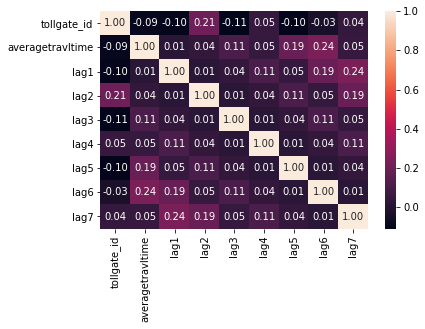

In [31]:
sns.heatmap(traj.corr(), annot = True, fmt = ".2f")
display()

<h2> Identify Holiday,Weekday,Weekend </h2>

In [32]:
def is_holiday(date_time):
    # Mid-Autumn Festival.
    if date_time.month == 9 and date_time.day >= 15 and date_time.day <= 17:
        return 1
    # National Day.
    elif date_time.month == 10 and date_time.day >= 1 and date_time.day <= 7:
        return 1
    return 0

In [33]:
def is_rush_hour(date_time):
    if date_time.hour == 8 or date_time.hour == 9 or date_time.hour == 17 or date_time.hour == 18:
        return 1
    
    return 0

In [34]:
#Identify the holidays
def identify_dates(df):
    df = df
    df['starting_time'] = pd.to_datetime(df['starting_time'], format="%Y-%m-%d %H:%M:%S")
    df['date']=df['starting_time'].dt.date
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['month'] = df['starting_time'].apply(lambda x: x.month)
    df['day'] = df['starting_time'].apply(lambda x: x.day)
    df['weekday'] = df['starting_time'].apply(lambda x: x.dayofweek)
    df['hour'] = df['starting_time'].apply(lambda x: x.hour)
    df['minute'] = df['starting_time'].apply(lambda x: x.minute)
    df['holiday'] = df['starting_time'].apply(lambda x: is_holiday(x))
    df['rush_hour'] = df['starting_time'].apply(lambda x: is_holiday(x))
    
    return df

In [35]:
traj = identify_dates(traj)

In [36]:
traj.head()

,starting_time,intersection_id,tollgate_id,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,lag7,date,month,day,weekday,hour,minute,holiday,rush_hour
0,2016-07-19 00:00:00,B,3,70.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-19,7,19,1,0,0,0,0
1,2016-07-19 00:20:00,A,2,58.05,70.85,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-19,7,19,1,0,20,0,0
2,2016-07-19 00:20:00,B,1,79.76,58.05,70.85,NaN,NaN,NaN,NaN,NaN,2016-07-19,7,19,1,0,20,0,0
3,2016-07-19 00:20:00,B,3,148.79,79.76,58.05,70.85,NaN,NaN,NaN,NaN,2016-07-19,7,19,1,0,20,0,0
4,2016-07-19 00:40:00,B,1,137.98,148.79,79.76,58.05,70.85,NaN,NaN,NaN,2016-07-19,7,19,1,0,40,0,0


In [37]:
traj.shape

(25592, 19)

<h2> Understand Weather Data </h2>

In [38]:
#weather training data from 01-Jul-2016 to 17-Oct-2016, measured at 3 hours interval
weather = pd.read_csv(train_path + 'weather (table 7)_training.csv',header=0) 
weather.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
1,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
3,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
4,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0


In [39]:
weather.shape

(782, 9)

In [40]:
#test weather data
test_weather = pd.read_csv(test_path + 'weather (table 7)_test1.csv',header=0) 
test_weather.shape

(56, 9)

<h2> Process Weather Data </h2>

In [41]:
#combine the two weather tables 
weather = weather.append(test_weather)
weather.shape

(838, 9)

In [42]:
# Extract month/day/dayofweek/hour/minute/holiday features from time window
# Reference from: https://github.com/chenzeyuczy/KDD2017/blob/master/code/load_data.py

def parse_weather_data(df):
    df = df
    df['time_window'] = pd.to_datetime(df.apply(lambda x: "{} {:02}".format(x.date, x.hour), axis=1))
    # Fix errors at wind_direction.
    df['wind_direction'] = df['wind_direction'].apply(lambda x: x % 360)
    #df.drop(['date', 'hour'], axis=1, inplace=True)
    df.set_index('time_window', inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    return df

In [43]:
weather = parse_weather_data(weather)
weather.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window,,,,,,,,,
2016-07-01 00:00:00,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
2016-07-01 03:00:00,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2016-07-01 06:00:00,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
2016-07-01 09:00:00,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
2016-07-01 12:00:00,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0


In [44]:
def get_mean_data(weather_data):
    mean_data = {}
    keys = ['pressure', 'sea_pressure', 'wind_direction', 'wind_speed',
        'temperature', 'rel_humidity', 'precipitation']
    for key in keys:
        mean_data[key] = weather_data[key].mean()
    return mean_data

In [45]:
# Calculate Mean Weather Data to fill NaN values
mean_weather = get_mean_data(weather)

In [46]:
# Fill nan in dataframe.
weather_columns = ['pressure', 'sea_pressure', 'precipitation', 'rel_humidity', 'temperature', 'wind_direction', 'wind_speed']
for column in weather_columns:
    weather[column].fillna(mean_weather[column], inplace=True)

In [47]:
weather.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window,,,,,,,,,
2016-07-01 00:00:00,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
2016-07-01 03:00:00,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2016-07-01 06:00:00,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
2016-07-01 09:00:00,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
2016-07-01 12:00:00,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0


In [48]:
weather.shape

(838, 9)

<h2> Combine Weather and Traffic Data </h2>

In [49]:
# Turn hour into 3 hour intervals and then combine with weather data
def addWeatherData(df):
    for i, row in df.iterrows():
        if row['hour'] in [23,0,1]: df.loc[i, "hour"] = 0
        elif row['hour'] in [2,3,4]: df.loc[i, "hour"] = 3 
        elif row['hour'] in [5,6,7]: df.loc[i, "hour"] = 6         
        elif row['hour'] in [8,9,10]: df.loc[i, "hour"] = 9         
        elif row['hour'] in [11,12,13]: df.loc[i, "hour"] = 12         
        elif row['hour'] in [14,15,16]: df.loc[i, "hour"] = 15         
        elif row['hour'] in [17,18,19]: df.loc[i, "hour"] = 18         
        elif row['hour'] in [20,21,22]: df.loc[i, "hour"] = 21
    return pd.merge(df,weather,on =['date', 'hour'] ,how='left')

In [50]:
traj_combine = addWeatherData(traj)
traj_combine.shape

(25592, 26)

In [51]:
traj_combine.head()

,starting_time,intersection_id,tollgate_id,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,...,minute,holiday,rush_hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-07-19 00:00:00,B,3,70.85,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,999.7,1004.5,239.0,1.9,31.8,64.0,0.0
1,2016-07-19 00:20:00,A,2,58.05,70.85,NaN,NaN,NaN,NaN,NaN,...,20,0,0,999.7,1004.5,239.0,1.9,31.8,64.0,0.0
2,2016-07-19 00:20:00,B,1,79.76,58.05,70.85,NaN,NaN,NaN,NaN,...,20,0,0,999.7,1004.5,239.0,1.9,31.8,64.0,0.0
3,2016-07-19 00:20:00,B,3,148.79,79.76,58.05,70.85,NaN,NaN,NaN,...,20,0,0,999.7,1004.5,239.0,1.9,31.8,64.0,0.0
4,2016-07-19 00:40:00,B,1,137.98,148.79,79.76,58.05,70.85,NaN,NaN,...,40,0,0,999.7,1004.5,239.0,1.9,31.8,64.0,0.0


In [52]:
traj_combine.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25592 entries, 0 to 25591
Data columns (total 26 columns):
starting_time       25592 non-null datetime64[ns]
intersection_id     25592 non-null object
tollgate_id         25592 non-null int64
averagetravltime    25592 non-null float64
lag1                25591 non-null float64
lag2                25590 non-null float64
lag3                25589 non-null float64
lag4                25588 non-null float64
lag5                25587 non-null float64
lag6                25586 non-null float64
lag7                25585 non-null float64
date                25592 non-null datetime64[ns]
month               25592 non-null int64
day                 25592 non-null int64
weekday             25592 non-null int64
hour                25592 non-null int64
minute              25592 non-null int64
holiday             25592 non-null int64
rush_hour           25592 non-null int64
pressure            22725 non-null float64
sea_pressure        22725 non-null

<h2> Combine with Routes </h2>

In [53]:
routes_copy = routes
routes_copy.head()

,intersection_id,tollgate_id,link_seq,link_count,route_length,in_link,out_link,min_width
0,A,2,"110,123,107,108,120,117",6,384,0,1,3
1,A,3,"110,123,107,108,119,114,118,122",8,852,1,2,3
2,B,1,"105,100,111,103,116,101,121,106,113",9,821,2,1,6
3,B,3,"105,100,111,103,122",5,477,2,1,3
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113",12,1550,2,1,6


In [54]:
routes_copy = routes_copy.drop(['link_seq'],axis=1)

In [55]:
final = pd.merge(traj_combine, routes_copy, on=['intersection_id', 'tollgate_id'],how='left')

In [56]:
final.shape

(25592, 31)

In [57]:
final.head()

,starting_time,intersection_id,tollgate_id,averagetravltime,lag1,lag2,lag3,lag4,lag5,lag6,...,wind_direction,wind_speed,temperature,rel_humidity,precipitation,link_count,route_length,in_link,out_link,min_width
0,2016-07-19 00:00:00,B,3,70.85,NaN,NaN,NaN,NaN,NaN,NaN,...,239.0,1.9,31.8,64.0,0.0,5,477,2,1,3
1,2016-07-19 00:20:00,A,2,58.05,70.85,NaN,NaN,NaN,NaN,NaN,...,239.0,1.9,31.8,64.0,0.0,6,384,0,1,3
2,2016-07-19 00:20:00,B,1,79.76,58.05,70.85,NaN,NaN,NaN,NaN,...,239.0,1.9,31.8,64.0,0.0,9,821,2,1,6
3,2016-07-19 00:20:00,B,3,148.79,79.76,58.05,70.85,NaN,NaN,NaN,...,239.0,1.9,31.8,64.0,0.0,5,477,2,1,3
4,2016-07-19 00:40:00,B,1,137.98,148.79,79.76,58.05,70.85,NaN,NaN,...,239.0,1.9,31.8,64.0,0.0,9,821,2,1,6


<h2> Save Processed Data </h2>

In [58]:
def timeperiod(Data, start_time, end_time):
    st = Data[start_time].apply(lambda k:k.strftime("%Y-%m-%d %H:%M:%S"))
    et = Data[end_time].apply(lambda k:k.strftime("%Y-%m-%d %H:%M:%S"))
    Data['time_window'] = '[' + st + ',' + et + ')'
    return Data.drop([start_time, end_time], axis=1)

In [59]:
final['end'] = final['starting_time'] + pd.DateOffset(minutes=20)
final = timeperiod(final, 'starting_time', 'end')

In [60]:
final = final.set_index(['intersection_id','tollgate_id','time_window'])

In [61]:
final.shape

(25592, 28)

In [62]:
def fill_nullvalues(data):
    return data.fillna(data.mean())

final =fill_nullvalues(final)


In [63]:
final.to_csv('training_20min_avg_travel_time.csv')